<h1 style="color: green;">Regression modelling Home Shopping Expenditure per week</h1>
<p>
The following tasks are accomplished in this section:
<ul>
<li>Hyperparameter tuning with GridSearchCV</li>
<li>Retrieving the best parameters for the top 4 models from GridSearchCV</li>
<li>Comparing VotingRegressor with the best model using cross validation</li>
<li>Working with the best model</li>
<li>Feature importance of the best model</li>
<li>Exporting the best model for evaluation</li>
</ul>

</p>

<h1 style="color: green;">Import libraries</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestRegressor as rf_r
from sklearn.ensemble import GradientBoostingRegressor as gb_r
from sklearn.ensemble import AdaBoostRegressor as adb_r
from xgboost import XGBRegressor as xgb_r
from catboost import CatBoostRegressor as catb_r
from lightgbm import LGBMRegressor as lgbm_r

from sklearn.ensemble import VotingRegressor as vot_r


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score


# Feature selection
from sklearn.feature_selection import SelectFromModel


import joblib

import warnings
warnings.filterwarnings('ignore')

<h1 style="color: green;">Load the data</h1>

In [23]:
X_train = pd.read_csv("../2. Data/homeshopping_Regressor_X_train.csv")
X_test = pd.read_csv("../2. Data/homeshopping_Regressor_X_test.csv")

In [24]:
X_train.shape

(655, 73)

In [3]:
X_train.head()

,Total_Nbr_of_Items,Total_Price,Date_diff,Nbr_trips_per_wk,Nbr_items_per_wk,Total_Exp_wk_perc,hour,Bread_wk,Bread_exp_wk,Bread_wk_exp_perc,...,Week_day_name_Monday,Week_day_name_Saturday,Week_day_name_Sunday,Week_day_name_Thursday,Week_day_name_Tuesday,Week_day_name_Wednesday,Part_of_day_Afternoon,Part_of_day_Evening,Part_of_day_Morning,target
0,0.086329,-0.236649,0.487672,-0.520909,-0.295981,-0.410729,-1.324821,2.398472,1.694186,0.381548,...,-0.449260,-0.483241,-0.326219,-0.393958,2.680951,-0.426978,-0.974374,-0.393958,1.445553,-0.294171
1,-0.816953,-0.320357,-0.516810,2.902459,0.983922,-0.972653,0.450253,0.566403,-0.473094,-0.494051,...,-0.449260,-0.483241,3.065424,-0.393958,-0.373002,-0.426978,1.026300,-0.393958,-0.691777,0.181543
2,1.170267,-0.134987,0.822500,-1.376752,-1.350020,0.465925,-0.310493,-0.349632,0.511028,3.008344,...,-0.449260,-0.483241,-0.326219,-0.393958,-0.373002,2.342039,1.026300,-0.393958,-0.691777,-0.330668
3,-0.455640,-0.307790,-0.181982,0.334933,0.758057,-0.974993,0.450253,0.566403,-0.473094,-0.494051,...,-0.449260,-0.483241,3.065424,-0.393958,-0.373002,-0.426978,1.026300,-0.393958,-0.691777,0.582345
4,-0.274984,-0.184135,-0.516810,-0.806190,0.231038,-0.460624,0.703836,0.566403,-0.473094,-0.494051,...,2.225881,-0.483241,-0.326219,-0.393958,-0.373002,-0.426978,1.026300,-0.393958,-0.691777,-0.188122


In [25]:
# Extract y_train and y_test from X_train and X_test
y_train = X_train.target.values
y_test = X_test.target.values

# drop y_train and y_test from X_train and X_test
X_train.drop(['target'], axis=1, inplace=True)
X_test.drop(['target'], axis=1, inplace=True)

In [4]:
X_train.head()

,Total_Nbr_of_Items,Total_Price,Date_diff,Nbr_trips_per_wk,Nbr_items_per_wk,Total_Exp_wk_perc,hour,Bread_wk,Bread_exp_wk,Bread_wk_exp_perc,...,Week_day_name_Friday,Week_day_name_Monday,Week_day_name_Saturday,Week_day_name_Sunday,Week_day_name_Thursday,Week_day_name_Tuesday,Week_day_name_Wednesday,Part_of_day_Afternoon,Part_of_day_Evening,Part_of_day_Morning
0,0.086329,-0.236649,0.487672,-0.520909,-0.295981,-0.410729,-1.324821,2.398472,1.694186,0.381548,...,-0.39654,-0.449260,-0.483241,-0.326219,-0.393958,2.680951,-0.426978,-0.974374,-0.393958,1.445553
1,-0.816953,-0.320357,-0.516810,2.902459,0.983922,-0.972653,0.450253,0.566403,-0.473094,-0.494051,...,-0.39654,-0.449260,-0.483241,3.065424,-0.393958,-0.373002,-0.426978,1.026300,-0.393958,-0.691777
2,1.170267,-0.134987,0.822500,-1.376752,-1.350020,0.465925,-0.310493,-0.349632,0.511028,3.008344,...,-0.39654,-0.449260,-0.483241,-0.326219,-0.393958,-0.373002,2.342039,1.026300,-0.393958,-0.691777
3,-0.455640,-0.307790,-0.181982,0.334933,0.758057,-0.974993,0.450253,0.566403,-0.473094,-0.494051,...,-0.39654,-0.449260,-0.483241,3.065424,-0.393958,-0.373002,-0.426978,1.026300,-0.393958,-0.691777
4,-0.274984,-0.184135,-0.516810,-0.806190,0.231038,-0.460624,0.703836,0.566403,-0.473094,-0.494051,...,-0.39654,2.225881,-0.483241,-0.326219,-0.393958,-0.373002,-0.426978,1.026300,-0.393958,-0.691777


In [26]:
X_train.shape

(655, 72)

<h1 style="color: green;">Hyperparameter tuning with GridSearchCV</h1>

In [6]:
keys = ['AdaBoost','Catboost','LightGBM','GradientBoosting','RandomForest','XGBoost']

models_list = {
    'AdaBoost': adb_r(),
    'Catboost': catb_r(),
    'LightGBM': lgbm_r(),
    'GradientBoosting': gb_r(),
    'RandomForest': rf_r(),
    'XGBoost':xgb_r()
}

param_list = {
    'AdaBoost': {
                'n_estimators': [100, 300, 500, 800, 1000, 1500, 5000, 10000],
                'learning_rate': [0.01, 0.03, 0.06, 0.08, 0.1, 0.15],
                'loss': ['linear','square'],
                'random_state': [44]
    },
    
    'Catboost': {
                'n_estimators': [100, 300, 500, 800, 1000, 1500, 5000, 10000],                
                'learning_rate': [0.01, 0.03, 0.06, 0.08, 0.1, 0.15],
                'depth': [4, 6, 8],
                'verbose': [False],
                'random_seed': [44]
    },
    
    'LightGBM':{
                'n_estimators': [100, 300, 500, 800, 1000, 1500, 5000, 10000],
                'learning_rate': [0.01, 0.03, 0.06, 0.08, 0.1, 0.15],
                'max_depth': [4, 6, 8, 10],
    },
    
    'GradientBoosting': {                
                'n_estimators': [100, 300, 500, 800, 1000, 1500, 5000, 10000],
                'learning_rate': [0.01, 0.03, 0.06, 0.08, 0.1, 0.15],
                'max_depth': [6, 8, 10],
                'loss': ['squared_error','huber'],
                'random_state': [44]
    },
    
    'RandomForest': {
                'n_estimators': [100, 300, 500, 800, 1000, 1500, 5000, 10000],
                'max_depth': [6, 8, 10, 12],
                'min_samples_split': [1, 3, 4, 6],
                'random_state': [44]
    },

    'XGBoost':{                
                'n_estimators': [100, 300, 500, 800, 1000, 1500, 5000, 10000],
                'learning_rate': [0.01, 0.03, 0.06, 0.08, 0.1, 0.15],
                'min_child_weight':[4,6,8],
                'max_depth':[4,6,8],
                'gamma':[0, 1],
                'random_state':[4]
    }
}


In [7]:
def gridSearch_run(keys, param_list, models_list, X_train, y_train, X_test, y_test):
    
    # Scoring metric
    # defining the scoring parameter to be passed into GridSearchCV
    # 'neg_mean_squared_error', metrics.mean_squared_error is used here
    # make_scorer and set greater_is_better to false to make sure 
    # GridSearchCV optimizes the hyperparameters correctly
    scoring_metrics = make_scorer(mean_squared_error, greater_is_better=False)

    # Alternative
    # scoring_metrics = "neg_mean_squared_error"

    key_model_params = []
    for key in keys:
        string = []
        string.append(key)
        string.append(param_list[key])

        gs = GridSearchCV(models_list[key],
                          param_grid=param_list[key],
                          cv=5, 
                          verbose=True, 
                          n_jobs=-1,
                          scoring=scoring_metrics
                         )

        #gs.fit(X_train,y_train)
        gs.fit(X_train, np.ravel(y_train))

        y_train_pred = gs.predict(X_train)
        y_test_pred = gs.predict(X_test)

        string.append(gs.best_params_)
        string.append(-gs.best_score_)
        string.append(np.sqrt(-gs.best_score_))

        string.append(explained_variance_score(y_train,y_train_pred))
        string.append(r2_score(y_train,y_train_pred))

        string.append(-gs.score(X_test,y_test))
        string.append(np.sqrt(-gs.score(X_test,y_test)))

        string.append(explained_variance_score(y_test,y_test_pred))
        string.append(r2_score(y_test,y_test_pred))
        key_model_params.append(string)


    return key_model_params
    
    
    

In [8]:
gridSearch_Output = gridSearch_run(keys, param_list, models_list, X_train, y_train, X_test,y_test)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


In [9]:
model_output = pd.DataFrame(gridSearch_Output, columns =['Model',
                                                            'Param_list_in',
                                                            'best_params',
                                                            'train_mse',
                                                            'train_rmse',
                                                            'Explained_var_train',
                                                            'R_squared_train',
                                                            'test_mse',
                                                            'test_rmse',
                                                            'Explained_var_test',
                                                            'R_squared_test'])
model_output.sort_values(by='test_mse', ascending=True)


,Model,Param_list_in,best_params,train_mse,train_rmse,Explained_var_train,R_squared_train,test_mse,test_rmse,Explained_var_test,R_squared_test
3,GradientBoosting,"{'n_estimators': [100, 300, 500, 800, 1000, 15...","{'learning_rate': 0.01, 'loss': 'huber', 'max_...",0.026284,0.162122,1.000000,1.000000,0.022035,0.148443,0.982923,0.982651
0,AdaBoost,"{'n_estimators': [100, 300, 500, 800, 1000, 15...","{'learning_rate': 0.03, 'loss': 'square', 'n_e...",0.073113,0.270395,0.951176,0.944947,0.058940,0.242775,0.957805,0.953596
1,Catboost,"{'n_estimators': [100, 300, 500, 800, 1000, 15...","{'depth': 4, 'learning_rate': 0.06, 'n_estimat...",0.044078,0.209948,1.000000,1.000000,0.120301,0.346845,0.906235,0.905286
5,XGBoost,"{'n_estimators': [100, 300, 500, 800, 1000, 15...","{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",0.063283,0.251560,0.999991,0.999991,0.129185,0.359423,0.900148,0.898292
4,RandomForest,"{'n_estimators': [100, 300, 500, 800, 1000, 15...","{'max_depth': 12, 'min_samples_split': 1, 'n_e...",0.182135,0.426773,0.972769,0.972756,0.231213,0.480846,0.818367,0.817964
2,LightGBM,"{'n_estimators': [100, 300, 500, 800, 1000, 15...","{'learning_rate': 0.06, 'max_depth': 4, 'n_est...",0.117028,0.342093,0.999983,0.999983,0.341380,0.584277,0.732933,0.731229


<h3 style="color: green;">Retrieving the best parameters for the models</h3>

In [11]:
# Retrieving the best params for GradientBoosting
x = model_output[['Model','best_params']].query("Model=='GradientBoosting'")
gbr_params = x.best_params.to_list()
gbr_params

[{'learning_rate': 0.01,
  'loss': 'huber',
  'max_depth': 8,
  'n_estimators': 10000,
  'random_state': 44}]

In [12]:
# Retrieving the best params for AdaBoost
x = model_output[['Model','best_params']].query("Model=='AdaBoost'")
adb_params = x.best_params.to_list()
adb_params

[{'learning_rate': 0.03,
  'loss': 'square',
  'n_estimators': 5000,
  'random_state': 44}]

In [13]:
# Retrieving the best params for Catboost
x = model_output[['Model','best_params']].query("Model=='Catboost'")
catb_params = x.best_params.to_list()
catb_params

[{'depth': 4,
  'learning_rate': 0.06,
  'n_estimators': 10000,
  'random_seed': 44,
  'verbose': False}]

In [14]:
# Retrieving the best params for XGBoost
x = model_output[['Model','best_params']].query("Model=='XGBoost'")
xgb_params = x.best_params.to_list()
xgb_params

[{'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 4,
  'min_child_weight': 8,
  'n_estimators': 1500,
  'random_state': 4}]

In [15]:
# Retrieving the best params for RandomForest
x = model_output[['Model','best_params']].query("Model=='RandomForest'")
rfr_params = x.best_params.to_list()
rfr_params

[{'max_depth': 12,
  'min_samples_split': 1,
  'n_estimators': 1500,
  'random_state': 44}]

In [16]:
# Retrieving the best params for LightGBM
x = model_output[['Model','best_params']].query("Model=='LightGBM'")
lgbm_params = x.best_params.to_list()
lgbm_params

[{'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 5000}]

<h3 style="color: green;">Cross validating with cross_val_score</h3>
<p>
Cross-validation provides information about how well a model generalizes i.e. how well the model can predict<br>
using previously unseen data. This is an indicator of the model's would be performance once deployed.
</p>

<h3 style="color: green;">Function to return rmse via cross validation</h3>

In [5]:
# RMSE function
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model,X,y, scoring="neg_mean_squared_error", cv=10))
    return rmse

<h3 style="color: green;">Model performance ranking by cross validation score</h3>

In [7]:
keys = ['AdaBoost','Catboost','LightGBM','GradientBoosting',
          'RandomForest','XGBoost']


models_list = {
    'AdaBoost': adb_r(
            n_estimators = 5000,
            learning_rate = 0.03,
            loss = 'square',
            random_state = 44      
    ),
    'Catboost': catb_r(
            learning_rate = 0.06,
            n_estimators = 10000,
            depth = 4,            
            random_seed = 44,
            verbose = False
    ),
    
    'LightGBM': lgbm_r(
            n_estimators = 5000,
            learning_rate = 0.06,
            max_depth = 4
    ),
    
    'GradientBoosting': gb_r(
            n_estimators = 10000,
            learning_rate = 0.01,
            max_depth = 8,
            loss = 'huber',
            random_state = 44       
    ),
    
    'RandomForest': rf_r(
            n_estimators = 1500,
            max_depth = 12,
            min_samples_split = 1,
            random_state = 44     
    ),
    'XGBoost':xgb_r(
            n_estimators = 1500,
            learning_rate = 0.1,
            max_depth = 4,
            min_child_weight = 8,
            gamma = 0,
            random_state = 4
    )
}

In [8]:
key_model_params = []

for key in keys:
    string = []
    
    rmse = rmse_cv(models_list[key],X_train, y_train)
    
    string.append(key)
    string.append(rmse.mean())
    
    key_model_params.append(string)

In [9]:
Cv_10_regressor = pd.DataFrame(key_model_params, 
                                columns =['Model',
                                          'rmse_cv'])

Cv_10_regressor.sort_values(by=['rmse_cv'], 
                                  ascending=True)

,Model,rmse_cv
3,GradientBoosting,0.132949
1,Catboost,0.195851
5,XGBoost,0.228794
0,AdaBoost,0.267038
2,LightGBM,0.295754
4,RandomForest,0.363437


<P>
On the basis of test rmse with cross validation score, the top 4 models are:
<ol>
    <li>GradientBoosting</li>
    <li>Catboost</li>
    <li>XGBoost</li>
    <li>AdaBoost</li>
</ol>    
<b>Surprisingly, XGBoost is not the best performing model.</b><br><br>
Below the best params for the top 4 models judging by test rmse will be used to compare the best model with an<br> ensemble voting regressor before a final decision is made as to which model we will go ahead with.<br>
</P>

<h3 style="color: green;">Ensemble VotingRegressor</h3>
<p>
Ensembles are used to achieve better predictive performance than a single predictive model. This operates on the <br>same principle as combining weak learners to collectively make a consistent decision, bagging/bootstrapping.<br>Thus the weakness of any one model is overcome by the crowd.
</p>
<p>
Below we group the four models, an ensemble, to see if they outperform the best amongst them, GradientBoosting on it's own.<br>Note, GradientBoosting GridSearch test mse is already low, the voting regressor must exhibit a significant improvement on this for it to be<br> considered worthy.
</p>

In [11]:
voting = vot_r([

            ('AdaBoost', adb_r(
                n_estimators = 5000,
                learning_rate = 0.03,
                loss = 'square',
                random_state = 44      
            )),

            ('Catboost', catb_r(
                learning_rate = 0.06,
                n_estimators = 10000,
                depth = 4,            
                random_seed = 44,
                verbose = False
            )),
            ('GradientBoosting', gb_r(
                n_estimators = 10000,
                learning_rate = 0.01,
                max_depth = 8,
                loss = 'huber',
                random_state = 44       
            )),

            ( 'XGBoost', xgb_r(
                n_estimators = 1500,
                learning_rate = 0.1,
                max_depth = 4,
                min_child_weight = 8,
                gamma = 0,
                random_state = 4
            ))
            ])


print("Number of models in the regressor: {0}".format(len(voting.estimators)))

# Fitting the models on X_train y_train
voting.fit(X_train, np.ravel(y_train))

Number of models in the regressor: 4


VotingRegressor(estimators=[('AdaBoost',
                             AdaBoostRegressor(learning_rate=0.03,
                                               loss='square', n_estimators=5000,
                                               random_state=44)),
                            ('Catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f84e99dc190>),
                            ('GradientBoosting',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       loss='huber',
                                                       max_depth=8,
                                                       n_estimators=10000,
                                                       random_state=44)),
                            ('XGBoost',
                             XGBRegressor(bas...
                                          gamma=0, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=4,
                                          max_leaves=None, min_child_weight=8,
                                          missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1500, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=4, ...))])

In [12]:
# Voting regressor without Gradient Boosting to see the absence effect
voting1 = vot_r([

            ('AdaBoost', adb_r(
                n_estimators = 5000,
                learning_rate = 0.03,
                loss = 'square',
                random_state = 44      
            )),

            ('Catboost', catb_r(
                learning_rate = 0.06,
                n_estimators = 10000,
                depth = 4,            
                random_seed = 44,
                verbose = False
            )),

            ( 'XGBoost', xgb_r(
                n_estimators = 1500,
                learning_rate = 0.1,
                max_depth = 4,
                min_child_weight = 8,
                gamma = 0,
                random_state = 4
            ))
            ])


print("Number of models in the regressor: {0}".format(len(voting.estimators)))

# Fitting the models on X_train y_train
voting1.fit(X_train, np.ravel(y_train))

Number of models in the regressor: 4


VotingRegressor(estimators=[('AdaBoost',
                             AdaBoostRegressor(learning_rate=0.03,
                                               loss='square', n_estimators=5000,
                                               random_state=44)),
                            ('Catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f84e99dcf70>),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_roun...
                                          gamma=0, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=4,
                                          max_leaves=None, min_child_weight=8,
                                          missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1500, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=4, ...))])

<h5 style="color: green;">Cross validating the voting regressors</h5>

In [13]:
voting_rmse = rmse_cv(voting,X_train,y_train)
voting_rmse

array([0.11889431, 0.22491934, 0.13857245, 0.32731321, 0.08957297,
       0.07583586, 0.0813212 , 0.13043127, 0.10138064, 0.30804757])

In [14]:
voting_rmse.mean()

0.15962888453477203

In [15]:
# voting without GradientBoosting cross validation
voting1_rmse = rmse_cv(voting1,X_train,y_train)
voting1_rmse


array([0.13335686, 0.26037359, 0.17230708, 0.40230587, 0.11787329,
       0.08952892, 0.102918  , 0.14174179, 0.12212847, 0.29303654])

In [16]:
voting1_rmse.mean()

0.1835570390658132

<b>
Above, it is clear that the exclusion of the GradientBoosting regressor increases the errors worsening the voting <br>regressor performance.
</b>

<h3 style="color: green;">GradientBoosting regressor best model</h3>

In [17]:
GB_reg = gb_r(
        n_estimators = 10000,
        learning_rate = 0.01,
        max_depth = 8,
        loss = 'huber',
        random_state = 44
    )

GB_reg.fit(X_train, np.ravel(y_train))

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=8,
                          n_estimators=10000, random_state=44)

<h5 style="color: green;">Cross validating the GradientBoosting regressor model</h5>

In [18]:
GB_reg_rmse = rmse_cv(GB_reg,X_train,y_train)
GB_reg_rmse

array([0.13614826, 0.16622675, 0.05241636, 0.1394412 , 0.02615679,
       0.12646481, 0.09273283, 0.12648051, 0.05987517, 0.40354908])

In [19]:
GB_reg_rmse.mean(), voting_rmse.mean(),voting1_rmse.mean()

(0.13294917632045977, 0.15962888453477203, 0.1835570390658132)

<p>
The cross validation output indicates that there is a difference between voting regressor and the <br> GradientBoosting regressor. It's the fact that the GradientBoosting model is powerful enough to be highly<br> predictive on it's own that the voting regressor can be discarded.<br><br>Further, there maybe efficiency improvement in deploying one model instead of an ensemble.
</p>

<h3 style="color: green;">Working with the best model, GradientBoosting regressor</h3>

In [20]:

# predict y_train
train_y_pred = GB_reg.predict(X_train)

# Retrieve the training rmse,r2_score
print("Training RMSE: {}".format(np.sqrt(mean_squared_error(y_train,train_y_pred))))
print("Training R-squared: {}\n".format(r2_score(y_train,train_y_pred)))


test_y_pred = GB_reg.predict(X_test)
# Retrieve the test rmse,r2_score
print("\nTest RMSE: {}".format(np.sqrt(mean_squared_error(y_test,test_y_pred))))
print("Test R-squared: {}".format(r2_score(y_test,test_y_pred)))

Training RMSE: 7.883781208604235e-05
Training R-squared: 0.9999999937845994


Test RMSE: 0.14844295126978366
Test R-squared: 0.9826514317293601


<h3 style="color: green;">Feature importance for GradientBoosting regressor</h3>

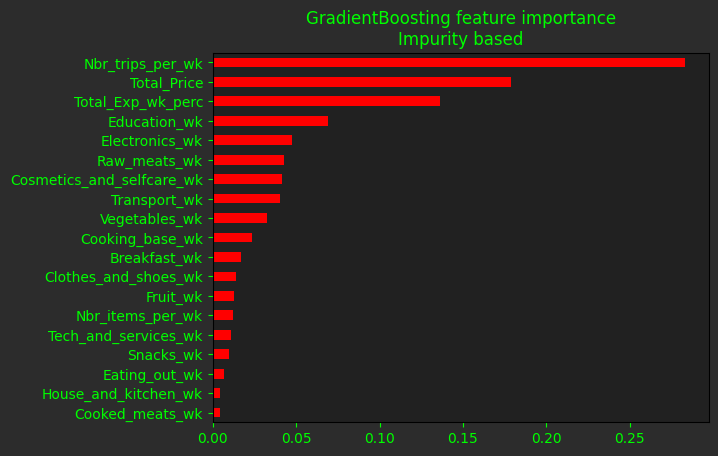

In [21]:
GBR_imp = pd.Series(GB_reg.feature_importances_, 
                    index=X_train.columns)

# plotting importance
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')


GBR_imp.nlargest(19).sort_values().plot(ax=ax,
                                        kind='barh', 
                                        color='red',
                                        title='GradientBoosting feature importance\nImpurity based')
plt.show()

<h3 style="color: green;">Exporting the best model from GridSearchCV</h3>
This is done for extracting feature importance list

In [22]:
joblib.dump(GB_reg, "../8. Models/Regressor_models/GB_reg_gridsearch_best_model")

['../8. Models/Regressor_models/GB_reg_gridsearch_best_model']